<a href="https://colab.research.google.com/github/LolitaOnayeva/Detecting-Mental-Health-Conditions-on-Reddit-using-NLP-and-machine-learning-/blob/main/Tune_10K_100D_GLOVE_NN_Mental_Health.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np 
import pandas as pd 
import csv 
import re
import matplotlib.pyplot as plt
plt.style.use('ggplot')

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import RandomizedSearchCV

from keras.models import Sequential
from keras import layers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.wrappers.scikit_learn import KerasClassifier

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/mental_health_data/full_mental_health_df.csv')

In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')
BAD_SYMBOLS_RE = re.compile('[^0-9a-z #+_]')
STOPWORDS = set(stopwords.words('english'))

def clean_text(text):
    """
        text: a string
        
        return: modified initial string
    """
    text = text.lower() # lowercase text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # replace REPLACE_BY_SPACE_RE symbols by space in text. substitute the matched string in REPLACE_BY_SPACE_RE with space.
    text = BAD_SYMBOLS_RE.sub('', text) # remove symbols which are in BAD_SYMBOLS_RE from text. substitute the matched string in BAD_SYMBOLS_RE with nothing. 
    text = text.replace('x', '')
#    text = re.sub(r'\W+', '', text)
    text = ' '.join(word for word in text.split() if word not in STOPWORDS) # remove stopwors from text
    return text
df['post'] = df['post'].apply(clean_text)
df['post'] = df['post'].str.replace('\d+', '')

In [ ]:
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 10000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 250
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(df['post'].values)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 215146 unique tokens.


In [ ]:
X = tokenizer.texts_to_sequences(df['post'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (152966, 250)


In [ ]:
Y = pd.get_dummies(df['subreddit']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (152966, 12)


In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.10, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(137669, 250) (137669, 12)
(15297, 250) (15297, 12)


In [ ]:
from keras.layers import Input, Embedding, Dense, LSTM,SpatialDropout1D,MaxPooling1D,Conv1D,Flatten,Dropout
from keras.models import Model

In [ ]:
def readGloveFile(gloveFile):
    with open(gloveFile, 'r') as f:
        wordToGlove = {}  
        wordToIndex = {}  
        indexToWord = {}  

        for line in f:
            record = line.strip().split()
            token = record[0] 
            wordToGlove[token] = np.array(record[1:], dtype=np.float64) 
            
        tokens = sorted(wordToGlove.keys())
        for idx, tok in enumerate(tokens):
            kerasIdx = idx + 1  
            wordToIndex[tok] = kerasIdx 
            indexToWord[kerasIdx] = tok 

    return wordToIndex, indexToWord, wordToGlove

In [ ]:
from keras.initializers import Constant

def createPretrainedEmbeddingLayer(wordToGlove, wordToIndex, isTrainable):
    vocabLen = len(wordToIndex) + 1  
    embDim = next(iter(wordToGlove.values())).shape[0]  
   
    embeddingMatrix = np.zeros((vocabLen, embDim))  
    for word, index in wordToIndex.items():
        embeddingMatrix[index, :] = wordToGlove[word] 

    embeddingLayer = Embedding(vocabLen, embDim, embeddings_initializer=Constant(embeddingMatrix), trainable=isTrainable, name='GloVe_Embeddings')
    return embeddingLayer

In [ ]:
n!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip '/content/glove.6B.zip'

--2021-07-25 14:48:20--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2021-07-25 14:48:20--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2021-07-25 14:48:20--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip.1’

glove

In [ ]:
# wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.50d.txt')
wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.100d.txt')
#wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.300d.txt')

# vocabLen = len(wordToIndex) + 1 

EMBED_SIZE = next(iter(wordToGlove.values())).shape[0]
print('Size of Embedding: ',EMBED_SIZE)

embeddingLayer=createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=True)

Size of Embedding:  100


In [ ]:
from keras.layers import Lambda, GlobalAveragePooling1D, Dense, Embedding

In [ ]:
class GlobalAveragePooling1DMasked(GlobalAveragePooling1D):
    def call(self, x, mask=None):
        if mask != None:
            return K.sum(x, axis=1) / K.sum(mask, axis=1)
        else:
            return super().call(x)

#LSTM 100


In [ ]:

target_input = Input((250,), dtype='int32')

target_embedding = embeddingLayer(target_input)

lstm =LSTM(100,return_sequences=False)(target_embedding)

label= Dense(12,activation='softmax')(lstm)

model = Model(inputs=target_input, outputs=label) 
model.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])


model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 250)]             0         
_________________________________________________________________
GloVe_Embeddings (Embedding) (None, 250, 100)          40000100  
_________________________________________________________________
lstm (LSTM)                  (None, 100)               80400     
_________________________________________________________________
dense (Dense)                (None, 12)                1212      
Total params: 40,081,712
Trainable params: 40,081,712
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train, Y_train,
                    epochs=10,
                    validation_data=(X_test, Y_test),
                    batch_size=512)

Epoch 1/10
269/269 [==============================] - 685s 2s/step - loss: 1.6483 - accuracy: 0.4441 - val_loss: 0.9894 - val_accuracy: 0.6497
Epoch 2/10
269/269 [==============================] - 656s 2s/step - loss: 0.8986 - accuracy: 0.6875 - val_loss: 0.8994 - val_accuracy: 0.6963
Epoch 3/10
269/269 [==============================] - 666s 2s/step - loss: 0.7294 - accuracy: 0.7477 - val_loss: 0.6717 - val_accuracy: 0.7618
Epoch 4/10
269/269 [==============================] - 667s 2s/step - loss: 0.6040 - accuracy: 0.7820 - val_loss: 0.6078 - val_accuracy: 0.7792
Epoch 5/10
269/269 [==============================] - 666s 2s/step - loss: 0.5301 - accuracy: 0.8054 - val_loss: 0.5747 - val_accuracy: 0.7885
Epoch 6/10
269/269 [==============================] - 666s 2s/step - loss: 0.4845 - accuracy: 0.8192 - val_loss: 0.5535 - val_accuracy: 0.7939
Epoch 7/10
269/269 [==============================] - 666s 2s/step - loss: 0.4505 - accuracy: 0.8305 - val_loss: 0.5527 - val_accuracy: 0.7985

In [ ]:
loss, accuracy = model.evaluate(X_train, Y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, Y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
#plot_history(history)

Training Accuracy: 0.8628
Testing Accuracy:  0.7942


In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
rounded_predictions = model.predict(X_test, batch_size=128, verbose=0)
rounded_predictions=np.argmax(rounded_predictions, axis=1)
rounded_predictions[1]

3

In [ ]:
rounded_labels=np.argmax(Y_test, axis=1)
rounded_labels[1]

In [ ]:
labels=['anxiety','bipolarreddit','conspiracy','depression','fitness','meditation','parenting',
        'personalfinance','schizophrenia','suicide','teaching','ptsd']
cm = confusion_matrix(rounded_labels, rounded_predictions)
cm

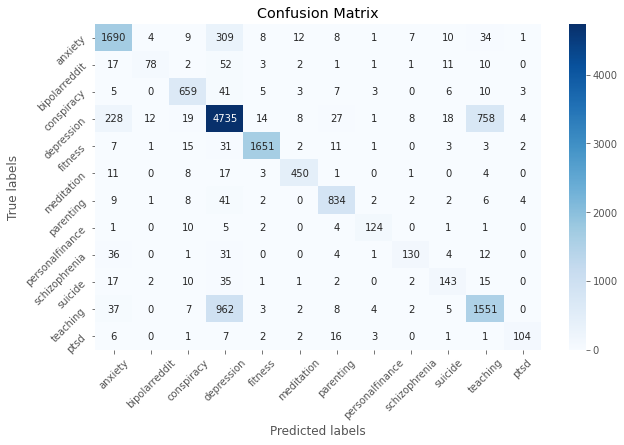

In [ ]:
fig = plt.figure(figsize=(10,6))
ax= plt.subplot()
sns.heatmap(cm, annot=True, cmap='Blues',fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.set_xticklabels(labels=labels,rotation=45); ax.set_yticklabels(labels=labels,rotation=45);

#CNN


In [ ]:

target_input = Input((250,), dtype='int32')

target_embedding = embeddingLayer(target_input)

convolution=Conv1D(64,3,activation='relu')(target_embedding)

global_average=GlobalAveragePooling1DMasked()(convolution)

label= Dense(12,activation='softmax')(global_average)

model2 = Model(inputs=target_input, outputs=label) 
model2.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
model2.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 250)]             0         
_________________________________________________________________
GloVe_Embeddings (Embedding) (None, 250, 100)          40000100  
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 248, 64)           19264     
_________________________________________________________________
global_average_pooling1d_mas (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 12)                780       
Total params: 40,020,144
Trainable params: 40,020,144
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model2.fit(X_train, Y_train,
                    epochs=10,
                    validation_data=(X_test, Y_test),
                    batch_size=512)

Epoch 1/10
269/269 [==============================] - 261s 909ms/step - loss: 1.8835 - accuracy: 0.3931 - val_loss: 1.1605 - val_accuracy: 0.6059
Epoch 2/10
269/269 [==============================] - 243s 904ms/step - loss: 1.0655 - accuracy: 0.6382 - val_loss: 0.8786 - val_accuracy: 0.7003
Epoch 3/10
269/269 [==============================] - 244s 905ms/step - loss: 0.8308 - accuracy: 0.7194 - val_loss: 0.7728 - val_accuracy: 0.7296
Epoch 4/10
269/269 [==============================] - 244s 908ms/step - loss: 0.7287 - accuracy: 0.7490 - val_loss: 0.7226 - val_accuracy: 0.7430
Epoch 5/10
269/269 [==============================] - 243s 905ms/step - loss: 0.6659 - accuracy: 0.7694 - val_loss: 0.6876 - val_accuracy: 0.7521
Epoch 6/10
269/269 [==============================] - 243s 904ms/step - loss: 0.6218 - accuracy: 0.7815 - val_loss: 0.6619 - val_accuracy: 0.7643
Epoch 7/10
269/269 [==============================] - 242s 900ms/step - loss: 0.5885 - accuracy: 0.7924 - val_loss: 0.6488 -

In [ ]:
loss, accuracy = model2.evaluate(X_train, Y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model2.evaluate(X_test, Y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.8108
Testing Accuracy:  0.7744


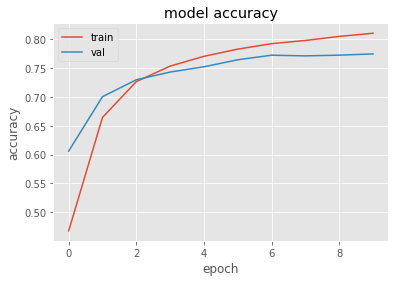

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
rounded_predictions2 = model2.predict(X_test, batch_size=128, verbose=0)
rounded_predictions2=np.argmax(rounded_predictions2, axis=1)
rounded_predictions2[1]
rounded_labels2=np.argmax(Y_test, axis=1)
rounded_labels2[1]

3

In [ ]:
labels=['anxiety','bipolarreddit','conspiracy','depression','fitness','meditation','parenting',
        'personalfinance','schizophrenia','suicide','teaching','ptsd']
cm2 = confusion_matrix(rounded_labels2, rounded_predictions2)
cm2

array([[1564,    1,    6,  455,    8,   16,    8,    1,   13,    6,   14,
           1],
       [  19,   48,    0,   74,    1,    2,    5,    2,    1,   18,    7,
           1],
       [   3,    0,  633,   72,    8,    6,   10,    4,    1,    2,    2,
           1],
       [ 123,   10,    7, 5177,   19,    4,   23,    3,    7,   10,  448,
           1],
       [   5,    0,    8,   44, 1663,    0,    7,    0,    0,    0,    0,
           0],
       [   8,    0,    3,   37,    3,  438,    3,    0,    0,    2,    1,
           0],
       [   5,    0,    6,   53,    6,    0,  830,    4,    1,    2,    3,
           1],
       [   1,    1,    6,    8,    2,    0,    6,  122,    0,    0,    2,
           0],
       [  33,    0,    3,   41,    0,    3,    4,    0,  119,    7,    8,
           1],
       [  12,    4,    7,   64,    0,    1,    6,    1,    9,  118,    6,
           0],
       [  16,    2,    4, 1494,    0,    0,    7,    5,    7,    0, 1046,
           0],
       [   4,    2,  

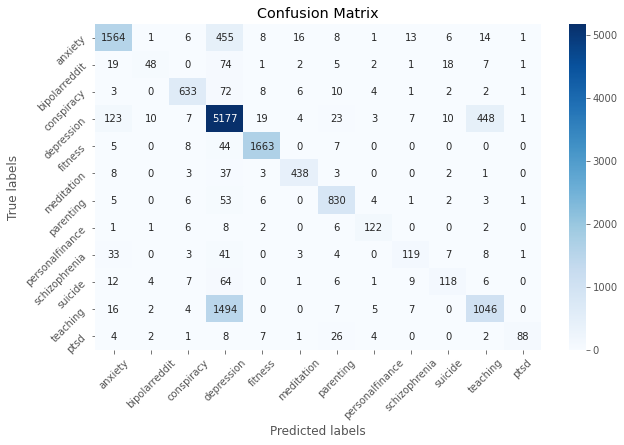

In [ ]:
fig = plt.figure(figsize=(10,6))
ax= plt.subplot()
sns.heatmap(cm2, annot=True, cmap='Blues',fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.set_xticklabels(labels=labels,rotation=45); ax.set_yticklabels(labels=labels,rotation=45);

#LSTM+CNN


In [ ]:
target_input = Input((250,), dtype='int32')

target_embedding = embeddingLayer(target_input)

convolution=Conv1D(64,3,activation='relu')(target_embedding)

lstm =LSTM(100,return_sequences=False)(convolution)

label= Dense(12,activation='softmax')(lstm)

model3 = Model(inputs=target_input, outputs=label) 
model3.compile(optimizer='adam', loss='categorical_crossentropy',metrics=['accuracy'])
model3.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 250)]             0         
_________________________________________________________________
GloVe_Embeddings (Embedding) (None, 250, 100)          40000100  
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 248, 64)           19264     
_________________________________________________________________
lstm (LSTM)                  (None, 100)               66000     
_________________________________________________________________
dense_2 (Dense)              (None, 12)                1212      
Total params: 40,086,576
Trainable params: 40,086,576
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model3.fit(X_train, Y_train,
                    epochs=10,
                    validation_data=(X_test, Y_test),
                    batch_size=512)

Epoch 1/10
269/269 [==============================] - 788s 3s/step - loss: 1.1761 - accuracy: 0.5966 - val_loss: 0.6114 - val_accuracy: 0.7753
Epoch 2/10
269/269 [==============================] - 789s 3s/step - loss: 0.5251 - accuracy: 0.8041 - val_loss: 0.5673 - val_accuracy: 0.7873
Epoch 3/10
269/269 [==============================] - 788s 3s/step - loss: 0.4679 - accuracy: 0.8242 - val_loss: 0.5457 - val_accuracy: 0.7945
Epoch 4/10
269/269 [==============================] - 787s 3s/step - loss: 0.4378 - accuracy: 0.8340 - val_loss: 0.5481 - val_accuracy: 0.7943
Epoch 5/10
269/269 [==============================] - 773s 3s/step - loss: 0.4233 - accuracy: 0.8374 - val_loss: 0.5630 - val_accuracy: 0.7889
Epoch 6/10
269/269 [==============================] - 785s 3s/step - loss: 0.4067 - accuracy: 0.8438 - val_loss: 0.5540 - val_accuracy: 0.7968
Epoch 7/10
269/269 [==============================] - 780s 3s/step - loss: 0.3930 - accuracy: 0.8475 - val_loss: 0.5572 - val_accuracy: 0.7960

In [ ]:
loss, accuracy = model3.evaluate(X_train, Y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model3.evaluate(X_test, Y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Training Accuracy: 0.8715
Testing Accuracy:  0.7901


In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
rounded_predictions3 = model3.predict(X_test, batch_size=128, verbose=0)
rounded_predictions3=np.argmax(rounded_predictions3, axis=1)
rounded_predictions3[1]
rounded_labels3=np.argmax(Y_test, axis=1)
rounded_labels3[1]

3

In [ ]:
labels=['anxiety','bipolarreddit','conspiracy','depression','fitness','meditation','parenting',
        'personalfinance','schizophrenia','suicide','teaching','ptsd']
cm3 = confusion_matrix(rounded_labels3, rounded_predictions3)
cm3

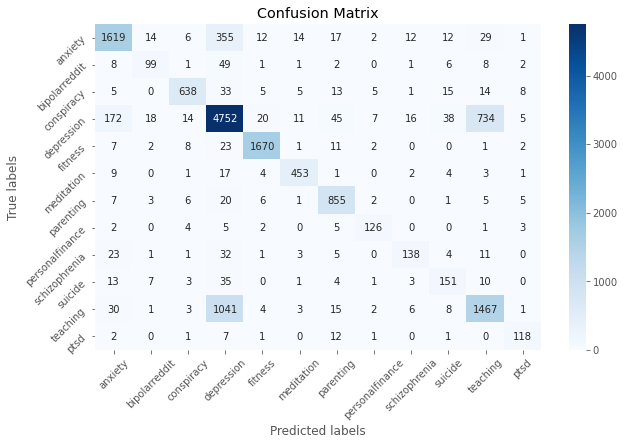

In [ ]:
fig = plt.figure(figsize=(10,6))
ax= plt.subplot()
sns.heatmap(cm3, annot=True, cmap='Blues',fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks

ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.set_xticklabels(labels=labels,rotation=45); ax.set_yticklabels(labels=labels,rotation=45);